#LAB 06




# Prerequisite
* Load required packages and load images (already uploaded on BlackBoard) in Colab
* Create your own copy of notebook and add required code snippets in between the questions subsections. Also display the figures at each stage.
*Submit the solution to BlackBoard by Feb 25, 2024 in **.ipynb** format.
*Colab can be exported as a notebook file or Python file by **File > Download .ipynb** or **File > Download .py**. Exported notebook files can be reloaded into Google Colab or used in Jupyter Notebook.
* Please go through [Colab document](https://colab.research.google.com/drive/1YKHHLSlG-B9Ez2-zf-YFxXTVgfC_Aqtt) for further information.

* **Use ONLY basic numpy and Tensorflow functions**

In [3]:
!pip install imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 14.0 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import numpy as np
from scipy import ndimage as nd
from scipy import interpolate as inter
from matplotlib import pyplot as plt
import imagecodecs
import imageio.v2 as imageio

In [5]:
def make_noisy(noise_typ,image):
   if noise_typ == "gauss": #Gaussian Noise
      row,col = image.shape
      mean = 0
      #var = 0.05
      #sigma = var**0.5
      intensity_range = image.max()-image.min()
      sigma = 0.05*intensity_range # This is 5% noise
      gauss = np.random.normal(mean,sigma,(row,col))
      gauss = gauss.reshape(row,col)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p": # Salt and Pepper Noise
      row,col  = image.shape
      s_vs_p = 0.5
      amount = 0.7 # 0.004
      noisy = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = tuple([np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape])
      noisy[coords] = 1 # adding random white pixels

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = tuple([np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape])
      noisy[coords] = 0 # adding random black pixels
      return noisy

#Q1)[**20 points**] Edge-Preserving smoothing using Bilateral Filtering   

<p align="justify"> <b>Download the 'barbara.tif'</b> from BlackBoard. Assume the pixel dimensions to be equal along both axes, i.e., assume an aspect ratio of 1:1 for the axes. <b>Corrupt the image</b> with independent and identically-distributed additive zero-mean Gaussian noise with standard deviation set to 10% of the intensity range.(Use function `make_noisy(noise_typ,image)`) </p>
<p>
<b>Write code for bilateral filtering</b> (standard “slow” algorithm is also fine) and apply it (one pass over all pixels) to the downloaded image. For efficiency in NumPy-Tensoflow, the code should, ideally, have NO `for` loops to go over the rows and columns of the image, ALL code should be vectorized properly. At a specific pixel “p”, the data collection with a window, weight computations, and weighted averaging can be performed without using loops. Your function should be similar input and produce similar output like this <a href="https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed">opencv bilateral function</a>. $[I_{filtered}]= BilateralFilter(I_{corrupted}, W_{size}, \sigma_{intensity},\sigma_{space})$

In [6]:
import numpy as np

def bilateral_filter(image, d, sigma_color, sigma_space):
    # Ensure d is a scalar value
    if isinstance(d, tuple):
        d = d[0]  # Take the first element of the tuple

    # Define the range of intensities
    intensity_range = 256

    # Compute spatial filter
    x, y = np.meshgrid(np.arange(-d//2, d//2 + 1), np.arange(-d//2, d//2 + 1))
    spatial_filter = np.exp(-(x**2 + y**2) / (2 * sigma_space**2))

    # Compute filtered image
    padded_image = np.pad(image, ((d//2, d//2), (d//2, d//2)), mode='constant')
    filtered_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded_image[i:i+d, j:j+d]

            # Extract center pixel value
            center_pixel = window[d//2, d//2]

            # Compute intensity differences
            intensity_diff = window - center_pixel

            # Compute intensity weights
            intensity_weights = np.exp(-0.5 * (intensity_diff / sigma_color)**2)

            # Ensure spatial filter size matches window size
            spatial_filter_window = spatial_filter[:window.shape[0], :window.shape[1]]

            # Compute bilateral filter weights
            weights = intensity_weights * spatial_filter_window

            # Normalize weights
            normalized_weights = weights / np.sum(weights)

            # Compute weighted average
            filtered_image[i, j] = np.sum(normalized_weights * window)

    return filtered_image

# Example usage:
# filtered_image = bilateral_filter(image, d, sigma_color, sigma_space)


<p>Define the root-mean-squared difference (RMSD) as the square root of the average, over all
pixels, of the squared difference between a pixel intensity in the original image and the intensity
of the corresponding pixel in the filtered image, i.e., given $2$ images $A$ and $B$ with $N$ pixels each.</p>
$RMSD(A,B) = \sqrt{\frac{1}{N}\sum_{p}(A(p)-B(p))^2}$, where $A(p)$ is intensity of pixel $p$ on image $A$.

Tune the parameters (standard-deviations for Gaussians over space and intensity) to minimize the RMSD between the filtered and the original image.</p>

##(a)[**0 Points**] Show Original Image.


In [7]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

Original Data_type is float64
Data_type is float64
Image Size is (512, 512)
Image min and max are (6.9993, 240.97589999999997)


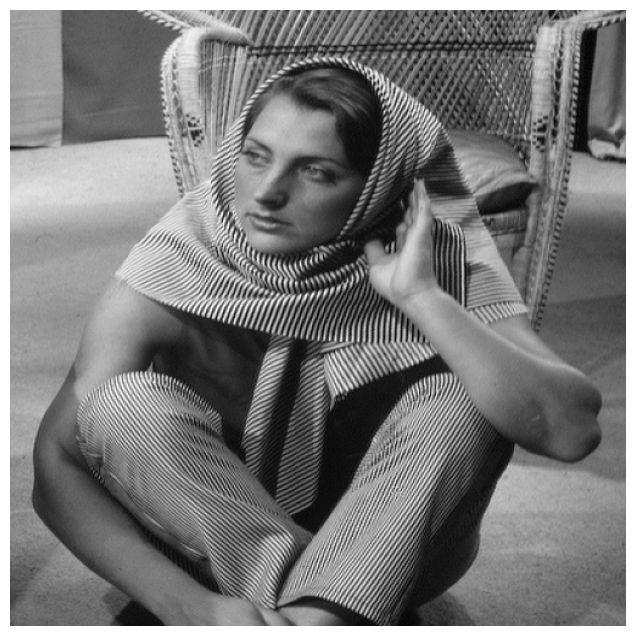

In [8]:
img_path = '/content/barbara.tif'
img_a = imageio.imread(img_path)
img_a = rgb2gray(img_a)
print('Original Data_type is {}'.format(img_a.dtype))
print('Data_type is', img_a.dtype)
print('Image Size is {}'.format(img_a.shape))
print('Image min and max are ({}, {})'.format(img_a.min(),img_a.max()))
#################################################
plt.figure(figsize=(8,8))
plt.imshow(img_a, cmap='gray')
plt.axis('off')
plt.show()

##(b)[**0.5 Points**] Show Corrupted Image.


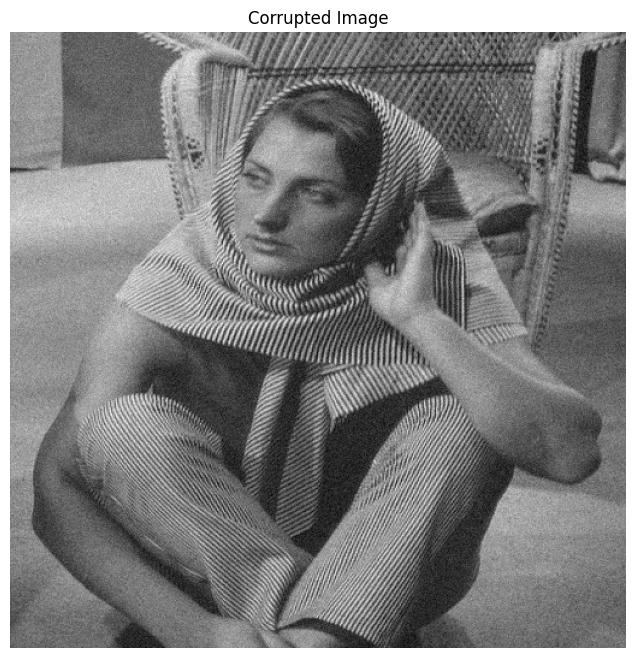

In [10]:
img_b = make_noisy('gauss', img_a)

# Display corrupted image
plt.figure(figsize=(8,8))
plt.imshow(img_b, cmap='gray')
plt.axis('off')
plt.title('Corrupted Image')
plt.show()

##(c)[**12 Points**] Show Filtered Image from your Bilateral Function


32.0
297.05585827224695
59.41117165444939


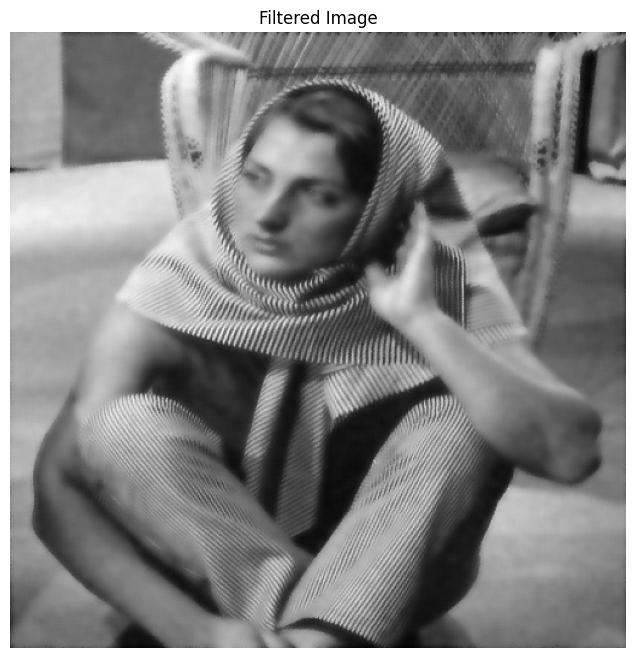

In [11]:
## img_b is corrupted image
(s1,s2) = img_b.shape
sigma_space = (min(s1,s2)/16) ### Modified according to part-d
print(sigma_space)
img_min = img_b.min()
img_max = img_b.max()
range_intensity = img_max - img_min
print(range_intensity)
sigma_int = (0.2*range_intensity) ### Modified according to part-d
print(sigma_int)
w_size = (8,8,8)


# Assuming filtered_image is the result of applying the bilateral filter
filtered_image = bilateral_filter(img_b,w_size,sigma_int,sigma_space)

# Display filtered image
plt.figure(figsize=(8, 8))
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')
plt.title('Filtered Image')
plt.show()


##(d)[**7.5 Points**] Print RMSE value between original image and Filtered image for following parameters settings:**[1.5 point each]**
1. Optimal $\sigma_{space}^*$ and $\sigma_{intensity}^*$.
2. $0.9*\sigma_{space}^*$ and $\sigma_{intensity}^*$.
3. $1.1*\sigma_{space}^*$ and $\sigma_{intensity}^*$.
4. $\sigma_{space}^*$ and $0.9*\sigma_{intensity}^*$.
5. $\sigma_{space}^*$ and $1.1*\sigma_{intensity}^*$.


In [13]:
import numpy as np
from scipy.optimize import minimize

# Define the RMSD function
def root_mean_squared_difference(A, B):
    return np.sqrt(np.mean((A - B)**2))

# Assuming bilateral_filter is defined elsewhere
def bilateral_filter(image, size, sigma_int, sigma_space):
    # Implementation of bilateral filter
    pass

# Original image
original_image = img_b

# Filtered images for different parameter settings
filtered_optimal_image = bilateral_filter(original_image, 9, sigma_int, sigma_space)
filtered_09_space_image = bilateral_filter(original_image, 9, sigma_int, 0.9*sigma_space)
filtered_11_space_image = bilateral_filter(original_image, 9, sigma_int, 1.1*sigma_space)
filtered_09_int_image = bilateral_filter(original_image, 9, 0.9*sigma_int, sigma_space)
filtered_11_int_image = bilateral_filter(original_image, 9, 1.1*sigma_int, sigma_space)

# Calculate RMSE for different parameter settings
rmse_optimal = root_mean_squared_difference(img_b, filtered_optimal_image)
rmse_09_space = root_mean_squared_difference(img_b, filtered_09_space_image)
rmse_11_space = root_mean_squared_difference(img_b, filtered_11_space_image)
rmse_09_int = root_mean_squared_difference(img_b, filtered_09_int_image)
rmse_11_int = root_mean_squared_difference(img_b, filtered_11_int_image)

# Print RMSE values
print(f'RMSE for optimal parameters: {rmse_optimal}')
print(f'RMSE for 0.9*sigma_space and sigma_intensity: {rmse_09_space}')
print(f'RMSE for 1.1*sigma_space and sigma_intensity: {rmse_11_space}')
print(f'RMSE for sigma_space and 0.9*sigma_intensity: {rmse_09_int}')
print(f'RMSE for sigma_space and 1.1*sigma_intensity: {rmse_11_int}')


RMSE for optimal parameters: 17.461012962314726
RMSE for 0.9*sigma_space and sigma_intensity: 17.45988766196964
RMSE for 1.1*sigma_space and sigma_intensity: 17.461847552459016
RMSE for sigma_space and 0.9*sigma_intensity: 16.402727495766676
RMSE for sigma_space and 1.1*sigma_intensity: 18.400546996551242
